#MNIST digit recognition using SVC in **scikit-learn**

#> Using optimal parameters, fit to BOTH original and deskewed data
---

In [1]:
from __future__ import division
import os, time, math
import cPickle as pickle
#import multiprocessing

import matplotlib.pyplot as plt
import numpy as np
import csv

from print_imgs import print_imgs # my own function to print a grid of square images

from sklearn.preprocessing    import StandardScaler
from sklearn.utils            import shuffle

from sklearn.svm              import SVC

from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search      import GridSearchCV

from sklearn.metrics          import classification_report, confusion_matrix
#from sklearn.externals        import joblib

np.random.seed(seed=1009)

%matplotlib inline

In [2]:
#%qtconsole  

##Where's the data?

In [3]:
file_path = '../data/'

train_img_deskewed_filename = 'train-images_deskewed.csv'
train_img_original_filename = 'train-images.csv'

test_img_deskewed_filename  = 't10k-images_deskewed.csv'
test_img_original_filename  = 't10k-images.csv'
    
train_label_filename   = 'train-labels.csv'
test_label_filename    = 't10k-labels.csv'

##How much of the data will we use?

In [4]:
portion = 1.0  # set to less than 1.0 for testing; set to 1.0 to use the entire dataset

##Read the training images and labels, both original and deskewed

In [5]:
# read both trainX files
with open(file_path + train_img_original_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainXo = np.ascontiguousarray(data, dtype = np.float64)  

with open(file_path + train_img_deskewed_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainXd = np.ascontiguousarray(data, dtype = np.float64)

# vertically concatenate the two files
trainX = np.vstack((trainXo, trainXd))

trainXo = None
trainXd = None

# scale trainX
scaler = StandardScaler()
scaler.fit(trainX)                 # find mean/std for trainX
trainX = scaler.transform(trainX)  # scale trainX with trainX mean/std

# read trainY twice and vertically concatenate
with open(file_path + train_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
trainYo = np.ascontiguousarray(data, dtype = np.int8) 
trainYd = np.ascontiguousarray(data, dtype = np.int8)

trainY = np.vstack((trainYo, trainYd)).ravel()

trainYo = None
trainYd = None
data    = None

# shuffle trainX & trainY
trainX, trainY = shuffle(trainX, trainY, random_state=0)

# use less data if specified
if portion < 1.0:
    trainX = trainX[:portion*trainX.shape[0]]
    trainY = trainY[:portion*trainY.shape[0]].ravel()

    
print("trainX shape: {0}".format(trainX.shape))
print("trainY shape: {0}\n".format(trainY.shape))

print(trainX.flags)

trainX shape: (120000, 784)
trainY shape: (120000, 1)

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  UPDATEIFCOPY : False


##Read the DESKEWED test images and labels

In [6]:
# read testX
with open(file_path + test_img_deskewed_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testX = np.ascontiguousarray(data, dtype = np.float64)  

if portion < 1.0:
    testX = testX[:portion*testX.shape[0]]

# scale testX
testX = scaler.transform(testX)    # scale testX with trainX mean/std


# read testY
with open(file_path + test_label_filename,'r') as f:
    data_iter = csv.reader(f, delimiter = ',')
    data      = [data for data in data_iter]
testY = np.ascontiguousarray(data, dtype = np.int8)

if portion < 1.0:
    testY = testY[:portion*testY.shape[0]].ravel()

# shuffle testX, testY
testX, testY = shuffle(testX, testY, random_state=0)

print("testX shape: {0}".format(testX.shape))
print("testY shape: {0}".format(testY.shape))

testX shape: (10000, 784)
testY shape: (10000, 1)


#Use the smaller, fewer images for testing

##Print a sample

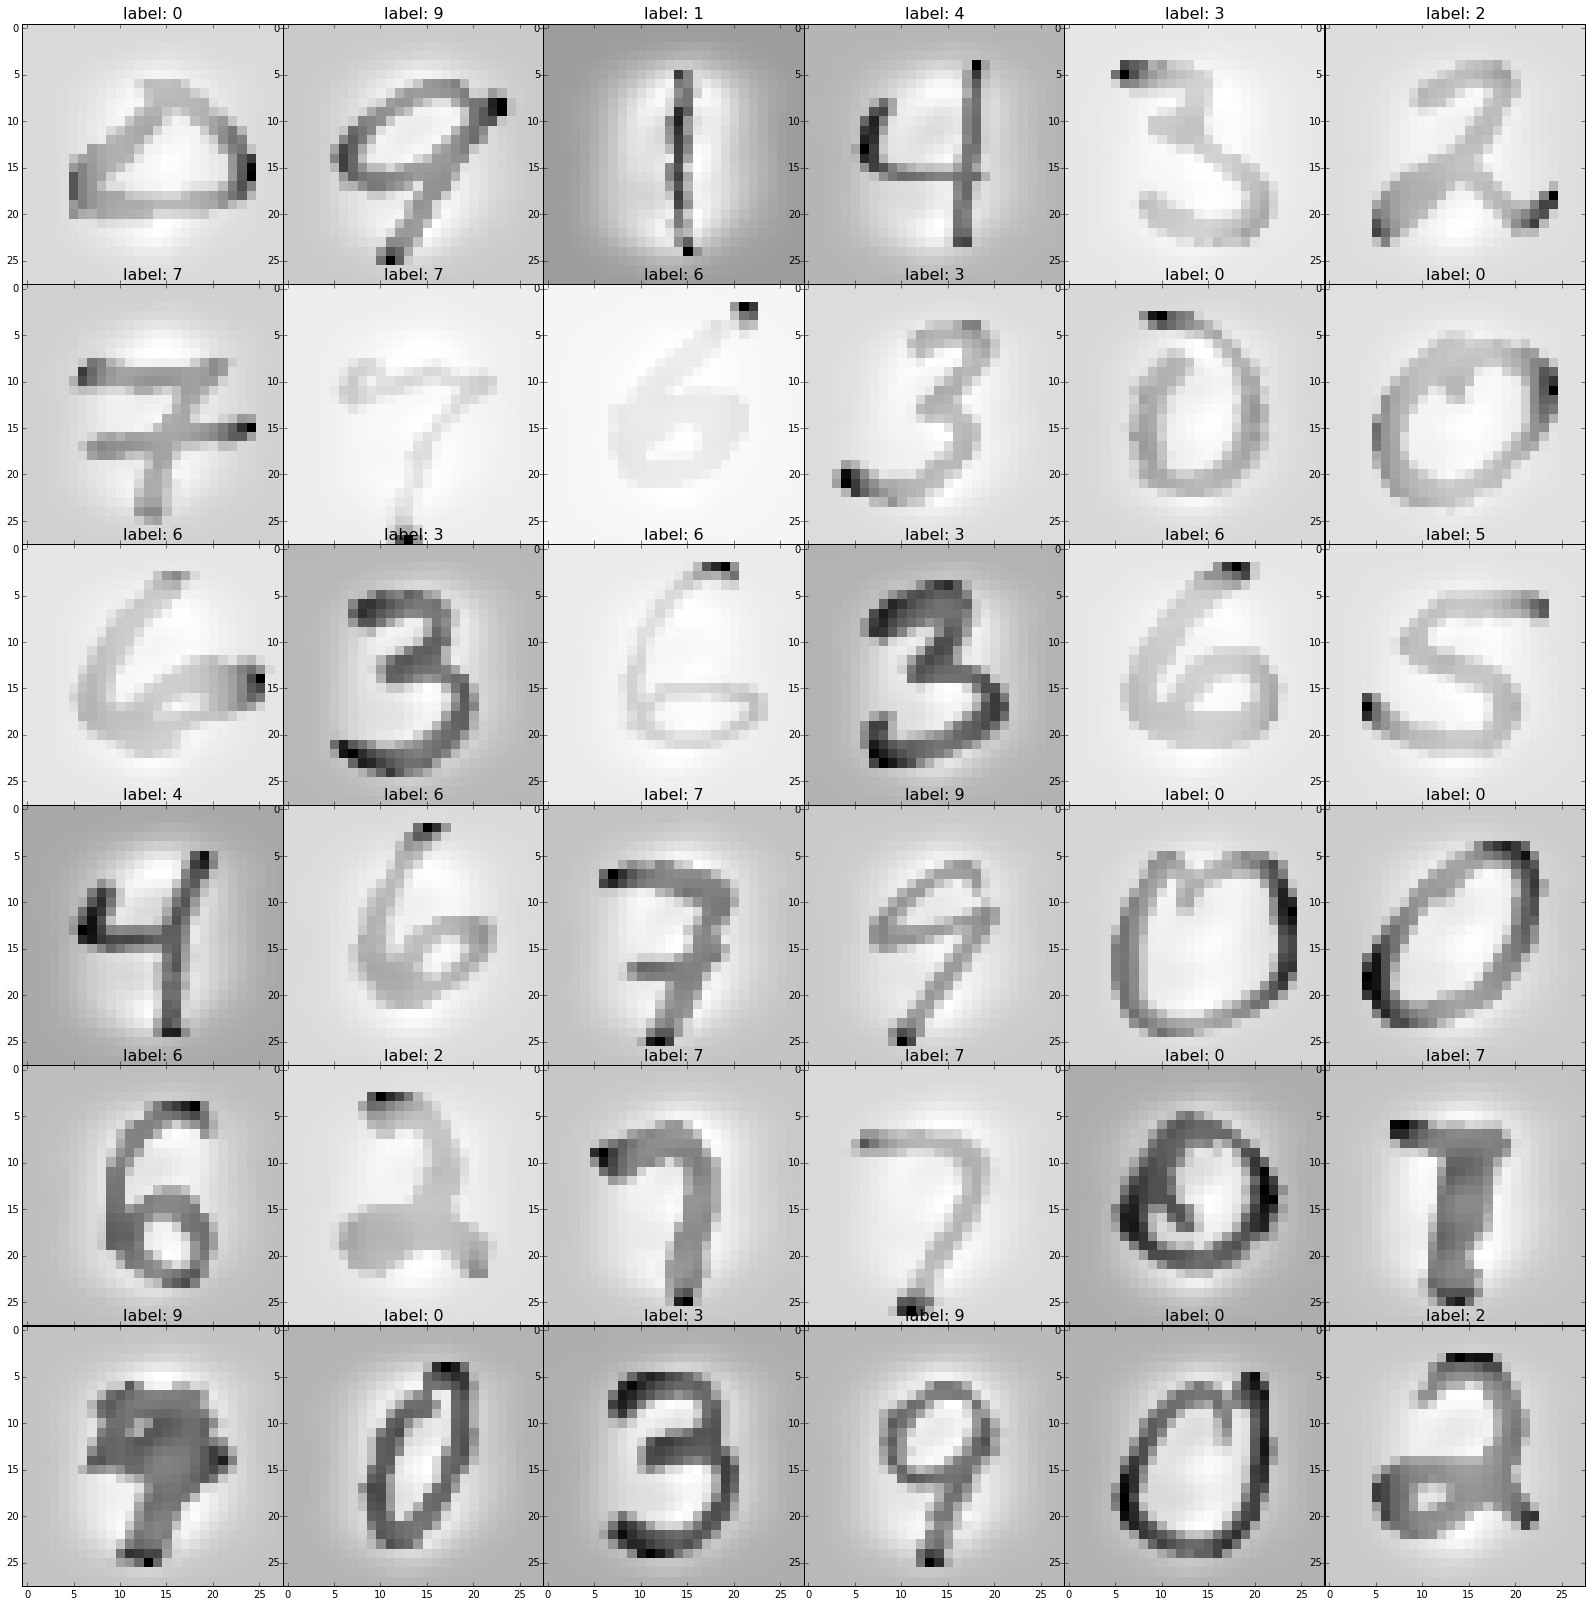

In [7]:
print_imgs(images           = trainX, 
           actual_labels    = trainY.ravel(), 
           predicted_labels = trainY.ravel(),
           starting_index   = np.random.randint(0, high=trainY.shape[0]-36, size=1)[0],
           size             = 6)

#SVC Parameter Settings

In [8]:
# default parameters for SVC
# ==========================
default_svc_params = {}

default_svc_params['C']            = 1.0      # penalty
default_svc_params['class_weight'] = None     # Set the parameter C of class i to class_weight[i]*C
                                              # set to 'auto' for unbalanced classes
default_svc_params['gamma']        = 0.0      # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'

default_svc_params['kernel']       = 'rbf'    # 'linear', 'poly', 'rbf', 'sigmoid', 'precomputed' or a callable
                                              # use of 'sigmoid' is discouraged
default_svc_params['shrinking']    = True     # Whether to use the shrinking heuristic.     
default_svc_params['probability']  = False    # Whether to enable probability estimates.    
default_svc_params['tol']          = 0.001    # Tolerance for stopping criterion. 
default_svc_params['cache_size']   = 200      # size of the kernel cache (in MB).

default_svc_params['max_iter']     = -1       # limit on iterations within solver, or -1 for no limit. 

default_svc_params['random_state'] = 1009    
default_svc_params['verbose']      = False 
default_svc_params['degree']       = 3        # 'poly' only
default_svc_params['coef0']        = 0.0      # 'poly' and 'sigmoid' only


# set the parameters for the classifier
# =====================================
svc_params = dict(default_svc_params)

svc_params['C']          = 25.595479226995359
svc_params['gamma']      = 0.00068664884500429981
svc_params['cache_size'] = 2000


# create the classifier itself
# ============================
svc_clf = SVC(**svc_params)

##Fit the training data

In [9]:
t0 = time.time()

svc_clf.fit(trainX, trainY.ravel())

print(svc_clf)

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))

SVC(C=25.595479227, cache_size=2000, class_weight=None, coef0=0.0, degree=3,
  gamma=0.000686648845004, kernel='rbf', max_iter=-1, probability=False,
  random_state=1009, shrinking=True, tol=0.001, verbose=False)

time in minutes 15.55


##Predict the test set and analyze the result

In [10]:
target_names     = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

predicted_values = svc_clf.predict(testX)
y_true, y_pred   = testY.ravel(), predicted_values

print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

          0       0.98      0.99      0.99       980
          1       0.99      0.99      0.99      1135
          2       0.98      0.97      0.98      1032
          3       0.99      0.99      0.99      1010
          4       0.98      0.98      0.98       982
          5       0.99      0.98      0.98       892
          6       0.98      0.98      0.98       958
          7       0.97      0.98      0.97      1028
          8       0.98      0.98      0.98       974
          9       0.98      0.97      0.98      1009

avg / total       0.98      0.98      0.98     10000



[[ 968    0    1    1    0    2    5    2    1    0]
 [   0 1129    1    1    0    1    1    1    1    0]
 [   6    1 1004    0    2    0    1    9    8    1]
 [   0    0    1  995    0    3    0    6    4    1]
 [   0    0    4    0  961    0    6    4    1    6]
 [   1    1    0    5    0  878    3    1    2    1]
 [   2    3    4    0    4    5  937    2    1    0]
 [   2    4    4    0    3    0    0 1008    1    6]
 [   3    0    4    4    2    0    0    3  956    2]
 [   2    2    1    2    9    2    1    8    0  982]]

Model accuracy: 0.9818, model misclass rate: 0.0182


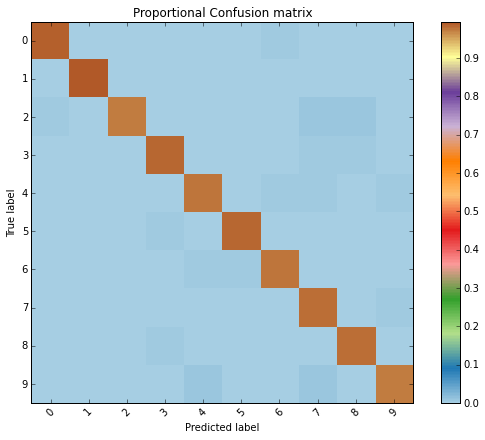

In [11]:
def plot_confusion_matrix(cm, 
                          target_names,
                          title='Proportional Confusion matrix', 
                          cmap=plt.cm.Paired):  
    """
    given a confusion matrix (cm), make a nice plot
    see the skikit-learn documentation for the original done for the iris dataset
    """
    plt.figure(figsize=(8, 6))
    plt.imshow((cm/cm.sum(axis=1)), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cm = confusion_matrix(y_true, y_pred)  

print(cm)
model_accuracy = sum(cm.diagonal())/len(testY)
model_misclass = 1 - model_accuracy
print("\nModel accuracy: {0}, model misclass rate: {1}".format(model_accuracy, model_misclass))

plot_confusion_matrix(cm, target_names)

##Learning Curves

see http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

* The score is the model accuracy
* The red line shows how well the model fits the data it was trained on: 
    * a high score indicates low bias ... the model does fit the training data
        * it's not unusual for the red line to start at 1.00 and decline slightly
    * a low score indicates the model does not fit the training data ... more predictor variables are ususally indicated, or a different model
    
* The green line shows how well the model predicts the test data: if it's rising then it means more data to train on will produce better predictions

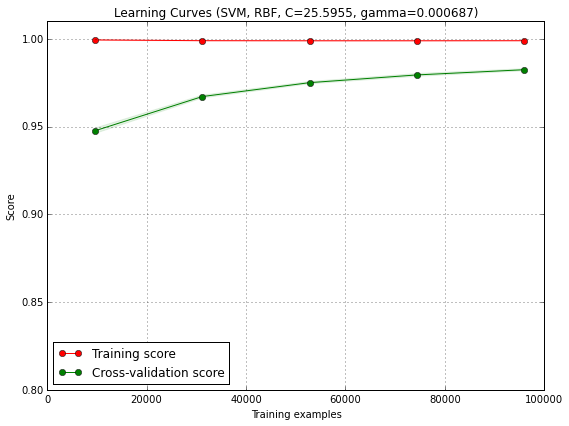


time in minutes 172.34


In [12]:
t0 = time.time()

from sklearn.learning_curve   import learning_curve
from sklearn.cross_validation import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.tight_layout()

    plt.legend(loc="best")
    return plt

C_gamma = "C="+str(np.round(svc_params['C'],4))+", gamma="+str(np.round(svc_params['gamma'],6))
title   = "Learning Curves (SVM, RBF, " + C_gamma + ")"

plot_learning_curve(estimator = svc_clf, 
                    title     = title, 
                    X         = trainX, 
                    y         = trainY.ravel(), 
                    ylim      = (0.85, 1.01), 
                    cv        = ShuffleSplit(n         = trainX.shape[0], 
                                             n_iter    = 5, 
                                             test_size = 0.2, 
                                             random_state=0), 
                    n_jobs    = 8)

plt.show()

print("\ntime in minutes {0:.2f}".format((time.time()-t0)/60))